# Debiasing Recidivism Predictions


Department of Computer Science

Stanford University

Team: Jonathan Hollenbeck, Manish Pandit and Amita C. Patil

(jonoh, manish7, amita2)@stanford.edu

Project mentor: [to be assigned]

## Overview

Recidivism is one of the most fundamental concepts in criminal justice. It refers to a person's relapse into criminal behavior, often after the person receives sanctions or undergoes intervention for a previous crime.

Across the nation, judges, probation and parole officers are increasingly using algorithms to assess a criminal defendant’s likelihood of becoming a recidivist. There are dozens of these risk assessment algorithms in use. Many states have built their own assessments, and several academics have written tools. There are also two leading nationwide tools offered by commercial vendors.

We set out to assess one of the commercial tools made by Northpointe, Inc. to discover the underlying accuracy of their recidivism algorithm and to test whether the algorithm was biased against certain groups.

Our goal is to detect any bias against certain groups exhibited the risk scores from Northpointe's algorithm named COMPAS.  We also investigate techniques and methods to reduce the bias while maintaining the accuracy of the predictions.

We plan to utilize the AI Fairness 360 toolkit from IBM.  The AI Fairness 360 toolkit is an open-source library to help detect and remove bias in machine learning models. The AI Fairness 360 Python package includes a comprehensive set of metrics for datasets and models to test for biases, explanations for these metrics, and algorithms to mitigate bias in datasets and models.

## Dataset

We leverage a dataset that contains more than 10,000 criminal defendants in Broward County, Florida. The dataset contains COMPAS software predicted recidivism rates along with the rate that actually occurred over a two-year period. When most defendants are booked in jail, they respond to a COMPAS questionnaire. Their answers are fed into the COMPAS software to generate several scores including predictions of “Risk of Recidivism” and “Risk of Violent Recidivism.”  We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.


## References
1. Machine learning bias in risk assessment.
https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing/
2. propublica analysis of compas recidivism algorithm.
https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/
3. The AI Fairness 360 toolkit is an open-source library to help detect and remove bias in machine learning models.
https://github.com/IBM/AIF360
4. Wikipedia 
https://en.wikipedia.org/wiki/Recidivism

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.

In [2]:
# datafiles
compas_file = 'compas-scores-two-years.csv'
#violent_file = 'compas-scores-two-years-violent.csv'

In [3]:
compas_df = pd.read_csv(compas_file)

There are a number of reasons to remove rows because of missing data:

1. If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
2. We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
3. In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
4. We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [4]:
compas_df = compas_df[np.isfinite(compas_df['days_b_screening_arrest'])]
compas_df = compas_df[compas_df['days_b_screening_arrest'] >= -30.]
compas_df = compas_df[compas_df['days_b_screening_arrest'] <= 30.]
compas_df = compas_df[compas_df['is_recid'] != -1]
compas_df = compas_df[compas_df['c_charge_degree'] != 'O']
compas_df = compas_df[compas_df['score_text'] != 'N/A']
jail_term = pd.to_datetime(compas_df['c_jail_out']) - pd.to_datetime(compas_df['c_jail_in'])
jail_term = pd.to_timedelta(jail_term)
compas_df['length_of_stay'] = jail_term.dt.days

In [5]:
column_list = [
    'sex', 'age', 'age_cat', 'race',
    'c_charge_degree', 'length_of_stay',
    'juv_fel_count', 'juv_misd_count', 'juv_other_count',
    'days_b_screening_arrest', 
    'priors_count', 'decile_score', 'score_text',
    'v_decile_score', 'v_score_text', 'is_recid', 'two_year_recid'
]
# not including c_charge_desc. One idea is to convert the text in this feature to
# sentence vectors and run some clustering algorithm to get categories.

In [6]:
compas_df = compas_df[column_list]

In [7]:
compas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6172 entries, 0 to 7213
Data columns (total 17 columns):
sex                        6172 non-null object
age                        6172 non-null int64
age_cat                    6172 non-null object
race                       6172 non-null object
c_charge_degree            6172 non-null object
length_of_stay             6172 non-null int64
juv_fel_count              6172 non-null int64
juv_misd_count             6172 non-null int64
juv_other_count            6172 non-null int64
days_b_screening_arrest    6172 non-null float64
priors_count               6172 non-null int64
decile_score               6172 non-null int64
score_text                 6172 non-null object
v_decile_score             6172 non-null int64
v_score_text               6172 non-null object
is_recid                   6172 non-null int64
two_year_recid             6172 non-null int64
dtypes: float64(1), int64(10), object(6)
memory usage: 867.9+ KB


In [8]:
compas_df.head()

,sex,age,age_cat,race,c_charge_degree,length_of_stay,juv_fel_count,juv_misd_count,juv_other_count,days_b_screening_arrest,priors_count,decile_score,score_text,v_decile_score,v_score_text,is_recid,two_year_recid
0,Male,69,Greater than 45,Other,F,0,0,0,0,-1.0,0,1,Low,1,Low,0,0
1,Male,34,25 - 45,African-American,F,10,0,0,0,-1.0,0,3,Low,1,Low,1,1
2,Male,24,Less than 25,African-American,F,1,0,0,1,-1.0,4,4,Low,3,Low,1,1
5,Male,44,25 - 45,Other,M,1,0,0,0,0.0,0,1,Low,1,Low,0,0
6,Male,41,25 - 45,Caucasian,F,6,0,0,0,-1.0,14,6,Medium,2,Low,1,1


### Demographic breakdown

In [9]:
compas_df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [10]:
print("Black defendants: %.2f%%" %            (3175 / 6172 * 100))
print("White defendants: %.2f%%" %            (2103 / 6172 * 100))
print("Hispanic defendants: %.2f%%" %         (509  / 6172 * 100))
print("Asian defendants: %.2f%%" %            (31   / 6172 * 100))
print("Native American defendants: %.2f%%" %  (11   / 6172 * 100))

Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%


In [11]:
compas_df['sex'].value_counts()

Male      4997
Female    1175
Name: sex, dtype: int64

In [12]:
print("Men: %.2f%%" %   (4997 / 6172 * 100))
print("Women: %.2f%%" % (1175 / 6172 * 100))

Men: 80.96%
Women: 19.04%


In [13]:
compas_df['age_cat'].value_counts()

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

### Corelation between lenght of stay in jail and decile score.
There is a positive corelation between length of stay and decile score, making it a useful feature for prediction.

In [14]:
compas_df[['length_of_stay', 'decile_score']].corr()

,length_of_stay,decile_score
length_of_stay,1.000000,0.207478
decile_score,0.207478,1.000000


In [15]:
compas_df['score_text'].value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

### Recidivism statistics

In [16]:
recid = compas_df['two_year_recid']
print('Number of recidivism cases:', recid[recid == 1].sum())
print('percentage of recidivism cases: %.2f%%' % (recid[recid == 1].sum() / len(recid)))

Number of recidivism cases: 2809
percentage of recidivism cases: 0.46%


Text(0.01, 0.5, 'Defendents')

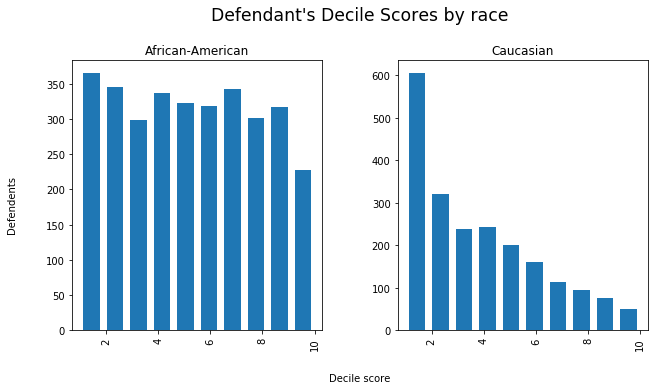

In [17]:
race_score_df = compas_df[['race', 'decile_score']]
race_score_df = race_score_df[(race_score_df['race'] 
                    == 'African-American') | (race_score_df['race'] == 'Caucasian')]
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(10,5))
race_score_df.hist(column='decile_score',by='race', ax=axes, rwidth=.7)

plt.suptitle("Defendant's Decile Scores by race",
             x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.01, 'Decile score', ha='center')
fig.text(0.01, 0.5, 'Defendents', va='center', rotation='vertical')

In [18]:
compas_df['sex'] = compas_df['sex'].astype('category')
compas_df['age_cat'] = compas_df['age_cat'].astype('category')
compas_df['race'] = compas_df['race'].astype('category')
compas_df['c_charge_degree'] = compas_df['c_charge_degree'].astype('category')
compas_df['score_text'] = compas_df['score_text'].astype('category')
compas_df['v_score_text'] = compas_df['v_score_text'].astype('category')
cat_columns = compas_df.select_dtypes(['category']).columns
compas_df[cat_columns] = compas_df[cat_columns].apply(lambda x: x.cat.codes)

In [19]:
compas_df.head()

,sex,age,age_cat,race,c_charge_degree,length_of_stay,juv_fel_count,juv_misd_count,juv_other_count,days_b_screening_arrest,priors_count,decile_score,score_text,v_decile_score,v_score_text,is_recid,two_year_recid
0,1,69,1,5,0,0,0,0,0,-1.0,0,1,1,1,1,0,0
1,1,34,0,0,0,10,0,0,0,-1.0,0,3,1,1,1,1,1
2,1,24,2,0,0,1,0,0,1,-1.0,4,4,1,3,1,1,1
5,1,44,0,5,1,1,0,0,0,0.0,0,1,1,1,1,0,0
6,1,41,0,2,0,6,0,0,0,-1.0,14,6,2,2,1,1,1


In [20]:
import sklearn
from sklearn.linear_model import LogisticRegressionCV as LR
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [21]:
def min_max_scaling(X):
    scalar = MinMaxScaler(feature_range=(-1,1))
    scalar_fit = scalar.fit(X)
    dmin = scalar.data_min_
    dmax = scalar.data_max_
    return scalar

In [22]:
Xy_df = compas_df
# prep train/dev datasets
Xy_train, Xy_test = train_test_split(Xy_df,test_size=0.2,random_state=42)
y_train = np.ndarray.astype(Xy_train.values[:,-1],int)
X_train = Xy_train.drop(Xy_train.columns[[0,-1]],axis=1)
y_test = np.ndarray.astype(Xy_test.values[:,-1],int)
X_test = Xy_test.drop(Xy_test.columns[[0,-1]],axis=1)
scalar = min_max_scaling(X_train)
X_train_norm = scalar.transform(X_train)
X_test_norm = scalar.transform(X_test)

/Users/manishpandit/stanford/cs221/recidivism/.env/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [23]:
# train initial model
clf = LR(penalty='l2', class_weight='balanced').fit(X_train_norm, y_train)
train_preds = clf.predict_proba(X_train_norm)[:,1]
test_preds = clf.predict_proba(X_test_norm)[:,1]
test_preds_label = clf.predict(X_test_norm)
class_preds = test_preds >= 0.5
train_ll = log_loss(y_train, train_preds)
test_ll = log_loss(y_test, test_preds)
print('test log-loss: ' + str(test_ll))

/Users/manishpandit/stanford/cs221/recidivism/.env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


test log-loss: 0.5912358825540546


In [24]:
# working with ai360 -- first, run on initial model (no debiasing)
from aif360.datasets import StandardDataset
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

In [25]:
def fairness_metrics(classified_metric, log=False): # prints instead of return if log=True
    TPR = classified_metric.true_positive_rate()
    TNR = classified_metric.true_negative_rate()
    bal_acc = np.round(0.5*(TPR+TNR),2)
    dip = np.round((1/classified_metric.disparate_impact() - 1)*100,2)
    aod = np.round(classified_metric.average_odds_difference(),2)
    spd = np.round(classified_metric.statistical_parity_difference(),2)
    eod = np.round(classified_metric.equal_opportunity_difference(),2)
    if log:
        print("Balanced Accuracy: " + str(bal_acc))
        print("Disparate Impact (%): " + str(dip))
        print("Average Odds Difference: " + str(aod))
        print("Statistical Parity Difference: " + str(spd))
        print("Equal Opportunity Difference: " + str(eod))
    else:
        return bal_acc,dip,aod,spd,eod

In [26]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

comp_dataset = BinaryLabelDataset(
    df=Xy_test, favorable_label=0, unfavorable_label = 1,
    label_names = ['two_year_recid'], protected_attribute_names = ['sex'],
    privileged_protected_attributes = [[0]],
    unprivileged_protected_attributes = [[1]]
)
comp_dataset_pred = comp_dataset.copy()
comp_dataset_pred.labels = test_preds_label
comp_dataset_pred.scores = test_preds

classified_metric = ClassificationMetric(
    comp_dataset, comp_dataset_pred, unprivileged_groups = unprivileged_groups,
    privileged_groups = privileged_groups)

In [27]:
fairness_metrics(classified_metric, log=True)

Balanced Accuracy: 0.98
Disparate Impact (%): -16.18
Average Odds Difference: 0.01
Statistical Parity Difference: 0.1
Equal Opportunity Difference: 0.02


In [28]:
# repeat with preprocessing
#from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
#from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
from aif360.algorithms.preprocessing.reweighing import Reweighing

cd_train = BinaryLabelDataset(
    df=Xy_train, favorable_label=0, unfavorable_label = 1,
    label_names = ['two_year_recid'], protected_attribute_names = ['sex'],
    privileged_protected_attributes = [[0]],
    unprivileged_protected_attributes = [[1]]
)
cd_test = BinaryLabelDataset(
    df=Xy_test, favorable_label=0, unfavorable_label = 1,
    label_names = ['two_year_recid'], protected_attribute_names = ['sex'],
    privileged_protected_attributes = [[0]],
    unprivileged_protected_attributes = [[1]]
)

RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(cd_train)
Xyt_train = RW.transform(cd_train)
Xyt_test = RW.transform(cd_test)

# prep train/dev datasets
yt_train = Xyt_train.labels.ravel()
Xt_train = Xyt_train.features
yt_test = Xyt_test.labels.ravel()
Xt_test = Xyt_test.features
scalar_fair = min_max_scaling(Xt_train)
Xt_train_norm = scalar_fair.transform(Xt_train)
Xt_test_norm = scalar_fair.transform(Xt_test)

# train initial model
clf = LR(penalty='l2', class_weight='balanced').fit(
    Xt_train_norm, yt_train, sample_weight=Xyt_train.instance_weights)
fair_train_preds = clf.predict_proba(Xt_train_norm)[:,1]
fair_test_preds = clf.predict_proba(Xt_test_norm)[:,1]
fair_test_preds_label = clf.predict(Xt_test_norm)
fair_class_preds = fair_test_preds >= 0.5
train_ll = log_loss(yt_train, fair_train_preds)
test_ll = log_loss(yt_test, fair_test_preds)
print('test log-loss: ' + str(test_ll))

# calculate fairness metrics for rebalanced model
fair_comp_dataset = BinaryLabelDataset(
    df=Xy_test, favorable_label=0, unfavorable_label = 1,
    label_names = ['two_year_recid'], protected_attribute_names = ['sex'],
    privileged_protected_attributes = [[0]],
    unprivileged_protected_attributes = [[1]]
)
fair_comp_dataset_pred = fair_comp_dataset.copy()
fair_comp_dataset_pred.labels = fair_test_preds_label
fair_comp_dataset_pred.scores = fair_test_preds

fair_classified_metric = ClassificationMetric(
    fair_comp_dataset, fair_comp_dataset_pred, unprivileged_groups = unprivileged_groups,
    privileged_groups = privileged_groups)

/Users/manishpandit/stanford/cs221/recidivism/.env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


test log-loss: 0.5915050174750616


In [29]:
fairness_metrics(fair_classified_metric, log=True)

Balanced Accuracy: 0.98
Disparate Impact (%): -16.18
Average Odds Difference: 0.01
Statistical Parity Difference: 0.1
Equal Opportunity Difference: 0.02
